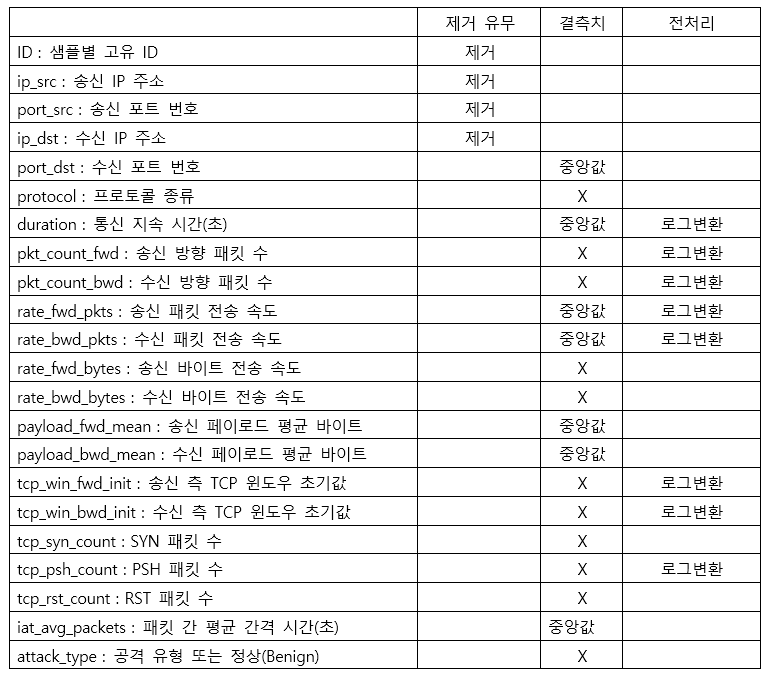

# <새로운 파생변수 만들기>
**1.   is_https**

HTTP(S)는 port_dst가 (80/443)이므로 is_https 파생변수 만들기

**2.   is_ssh**

SSH는 port_dst가 22이므로 is_ssh 파생변수 만들기

**3.   pkt_ratio**

pkt_ratio=pkt_count_fwd / (pkt_count_bwd + 1)인데, 이때 pkt_count_bwd가 0이면 분모가 0이 되므로 이것을 막고자 1을 더했다.

+히트맵을 그려봤을 때, payload_fwd_mean와 payload_bwd_mean의 상관계수가 1이 나와서 다중공산성 문제로 둘 중에 하나의 변수를 제거하는 게 좋지 않을까? 생각이 듭니다.

**제가 수요일/금요일 회의에 참여하기 어려울 것 같아서 깃허브에 제출한 파일을 간단하게 정리하였습니다.**
__________________________


### 코드 정리
1.   ID, ip_src, ip_dst는 범주형이거나 ip번호여서 이 부분을 모델이 직접 사용하지 않는게 좋을 것 같다고 생각합니다.

In [ ]:
import pandas as pd
train=pd.read_csv('train.csv')

In [ ]:
train.head()

ID         ip_src  port_src          ip_dst  port_dst protocol  \
0  TRAIN_00000  192.168.10.18    3721.0  192.168.10.243      55.0      UDP   
1  TRAIN_00001   192.168.10.5       NaN             NaN      91.0      TCP   
2  TRAIN_00002   172.16.0.182       NaN   192.168.10.18      83.0      TCP   
3  TRAIN_00003            NaN   47668.0   192.168.10.18       NaN      TCP   
4  TRAIN_00004   192.168.10.5   51753.0   151.101.2.116     451.0      TCP   

     duration  pkt_count_fwd  pkt_count_bwd  rate_fwd_pkts  ...  \
0    0.000231              2              2    8656.974200  ...   
1    0.000000              0              1       0.000000  ...   
2    0.606002             11              5      18.151760  ...   
3    1.003829              6              6       5.977114  ...   
4  181.195271             62             89            NaN  ...   

   rate_bwd_bytes  payload_fwd_mean  payload_bwd_mean  tcp_win_fwd_init  \
0    1.142721e+06         81.000000         81.000000                 0   
1    0.000000e+00          0.000000          0.000000                 0   
2    1.913360e+04        790.125000        790.125000             29200   
3    1.155077e+04        993.416667        993.416667             29200   
4    6.896758e+02               NaN               NaN              8192   

   tcp_win_bwd_init  tcp_syn_count  tcp_psh_count  tcp_rst_count  \
0                 0              0              0              0   
1             16392              0              0              0   
2             28960              2              4              1   
3             28960              3              2              0   
4             29200              2             22              0   

   iat_avg_packets  attack_type  
0              NaN       Benign  
1     1.499097e+09       Benign  
2     4.040012e-02         Hulk  
3     9.125718e-02         Hulk  
4              NaN       Benign  

[5 rows x 22 columns]

In [ ]:
train['attack_type'].value_counts()

attack_type
Benign             8791
Hulk               1719
Port_Scanning       793
DDoS                471
FTP_Brute_Force      47
GoldenEye            41
Slow_HTTP            34
SSH_Brute_Force      30
Botnet               27
Slowloris            26
Web_Brute_Force      14
Web_XSS               6
Name: count, dtype: int64

In [ ]:
train.shape

(11999, 22)

In [ ]:
train=train.drop(['ID','ip_src','ip_dst'], axis=1)

In [ ]:
train.isnull().sum()

port_src            3374
port_dst            2287
protocol               0
duration            1074
pkt_count_fwd          0
pkt_count_bwd          0
rate_fwd_pkts       1171
rate_bwd_pkts       1687
rate_fwd_bytes         0
rate_bwd_bytes         0
payload_fwd_mean    1785
payload_bwd_mean    1785
tcp_win_fwd_init       0
tcp_win_bwd_init       0
tcp_syn_count          0
tcp_psh_count          0
tcp_rst_count          0
iat_avg_packets     2760
attack_type            0
dtype: int64

결측치를 보았을때에 port_src의 경우에는 결측치가 11999 중에서 3374로 약 28%정도이며

port_src는 송신 측 포트번호로 저희가 하는 주제는 사이버 공격 유형을 예측하는 것이어서 없어도 괜찮을 것 같습니다.

**-> port_src는 제거하는게 좋을 것 같다고 생각합니다.**



In [ ]:
train=train.drop(['port_src'], axis=1)

In [ ]:
train.head()

port_dst protocol    duration  pkt_count_fwd  pkt_count_bwd  rate_fwd_pkts  \
0      55.0      UDP    0.000231              2              2    8656.974200   
1      91.0      TCP    0.000000              0              1       0.000000   
2      83.0      TCP    0.606002             11              5      18.151760   
3       NaN      TCP    1.003829              6              6       5.977114   
4     451.0      TCP  181.195271             62             89            NaN   

   rate_bwd_pkts  rate_fwd_bytes  rate_bwd_bytes  payload_fwd_mean  \
0    8656.974200   259709.226006    1.142721e+06         81.000000   
1       0.000000        0.000000    0.000000e+00          0.000000   
2       8.250800     1727.717487    1.913360e+04        790.125000   
3       5.977114      324.756507    1.155077e+04        993.416667   
4       0.491183        6.573019    6.896758e+02               NaN   

   payload_bwd_mean  tcp_win_fwd_init  tcp_win_bwd_init  tcp_syn_count  \
0         81.000000                 0                 0              0   
1          0.000000                 0             16392              0   
2        790.125000             29200             28960              2   
3        993.416667             29200             28960              3   
4               NaN              8192             29200              2   

   tcp_psh_count  tcp_rst_count  iat_avg_packets attack_type  
0              0              0              NaN      Benign  
1              0              0     1.499097e+09      Benign  
2              4              1     4.040012e-02        Hulk  
3              2              0     9.125718e-02        Hulk  
4             22              0              NaN      Benign

port_dist의 경우에는 결측치가 2287개가 있다. port_dist의 히스토그램을 보면 0~500사이에 많은 데이터가 분포 되어 있는 것을 알 수 있다. 왜도는 약 2.4정도로 오른쪽으로 꼬리가 길다는 것을 알 수 있다.

**-> port_dist는 결측치를 중앙값으로 대체한다.**

2.4367514813258206


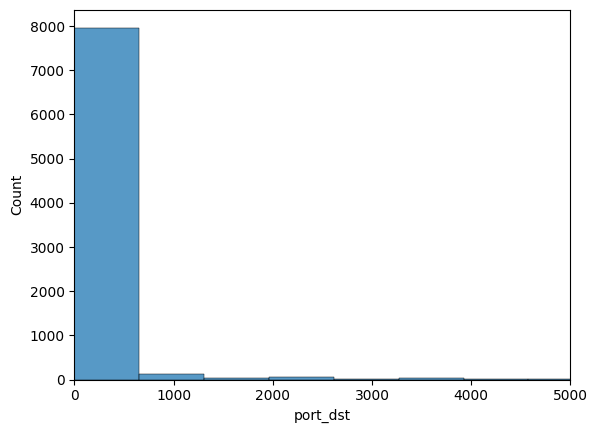

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
print(train['port_dst'].skew())
sns.histplot(train['port_dst'], bins=100, kde=False)
plt.xlim(0, 5000)
plt.show()

In [ ]:
train['port_dst'].fillna(train['port_dst'].median())

0         55.0
1         91.0
2         83.0
3         83.0
4        451.0
         ...  
11994     49.0
11995     54.0
11996     83.0
11997     83.0
11998     75.0
Name: port_dst, Length: 11999, dtype: float64

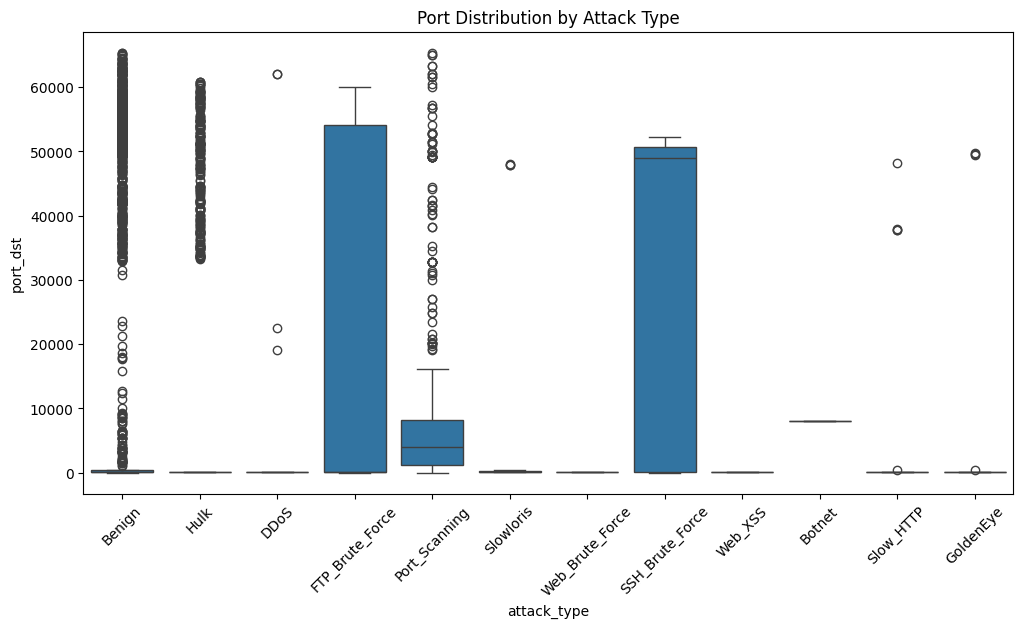

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='attack_type', y='port_dst', data=train)
plt.xticks(rotation=45)
plt.title("Port Distribution by Attack Type")
plt.show()

duration의 경우에는 히스토그램과 왜도를 보게 되면 왜도가 10이상으로 로그변환을 하는 것이 좋을 것 같다. 그래서 결측치를 처리할때에 평균보다는 중앙값을 이용하는 것이 좋을 것 같다.

**-> duration : 결측치는 중앙값으로 + 로그변환**

51.982621492927706


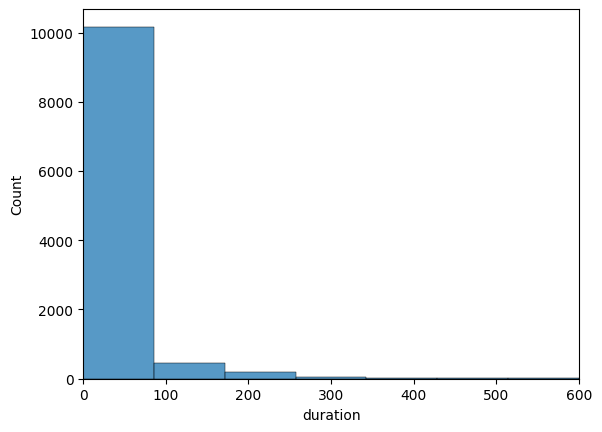

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
print(train['duration'].skew())
sns.histplot(train['duration'], bins=100, kde=False)
plt.xlim(0, 600)
plt.show()

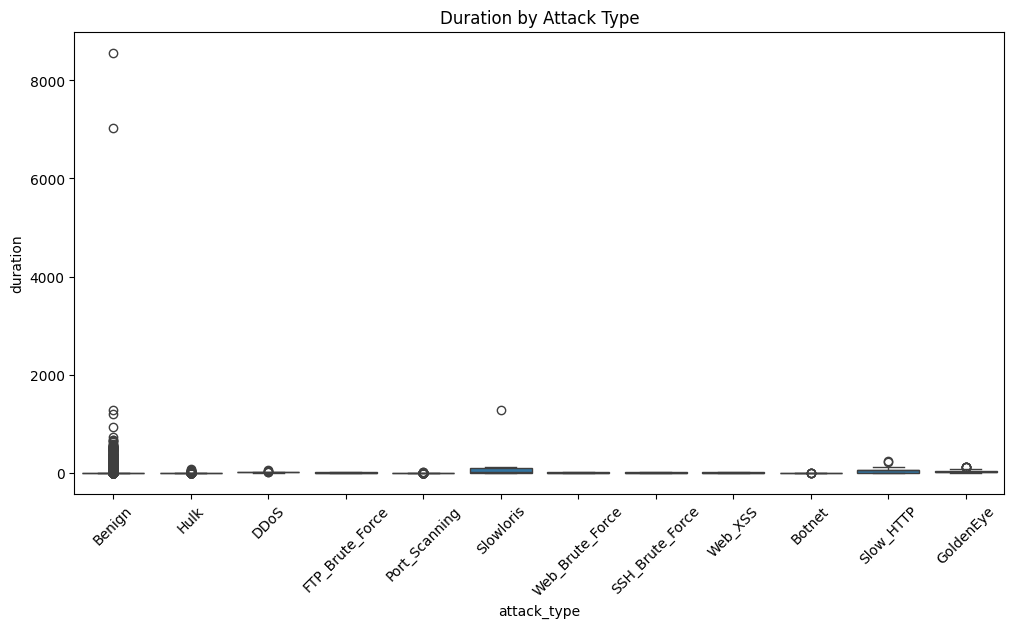

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='attack_type', y='duration', data=train)
plt.xticks(rotation=45)
plt.title("Duration by Attack Type")
plt.show()

In [ ]:
#duration에서 결측치를 중앙값으로 처리
train['duration'].fillna(train['duration'].median())

0          0.000231
1          0.000000
2          0.606002
3          1.003829
4        181.195271
            ...    
11994      0.023636
11995      0.061452
11996      0.049973
11997      0.047832
11998      0.169985
Name: duration, Length: 11999, dtype: float64

In [ ]:
import numpy as np
train['duration']=np.log1p(train['duration'])

2.0761250542164933


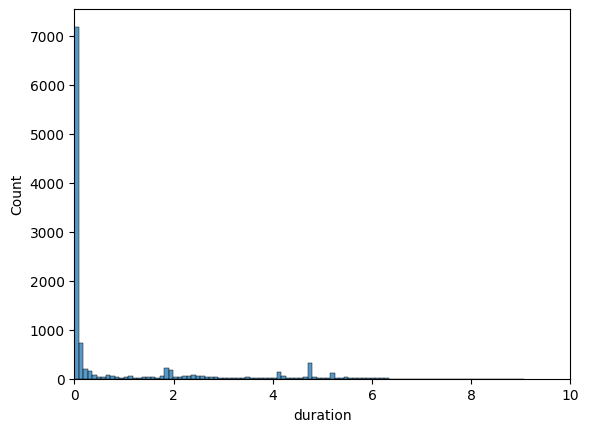

In [ ]:
#결측치 처리 + 로그변환 이후
import matplotlib.pyplot as plt
import seaborn as sns
print(train['duration'].skew())
sns.histplot(train['duration'], bins=100, kde=False)
plt.xlim(0, 10)
plt.show()

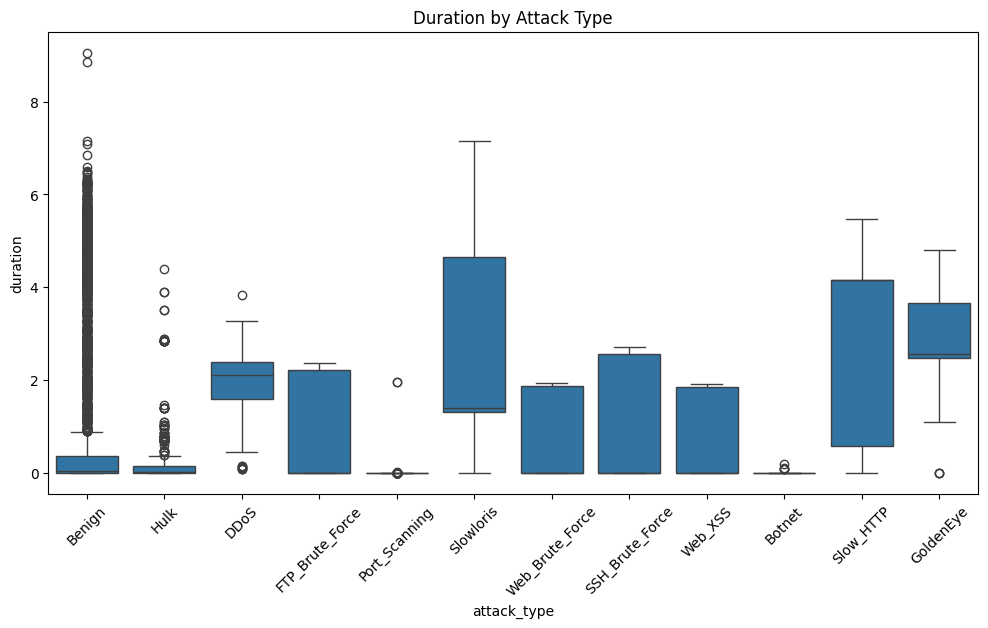

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='attack_type', y='duration', data=train)
plt.xticks(rotation=45)
plt.title("Duration by Attack Type")
plt.show()

pkt_count_fwd의 경우에는 boxplot과 왜도를 보게 되면 왜도가 10이상으로 로그변환을 하는 것이 좋을 것 같다.

**-> pkt_count_fwd : 로그변환**

In [ ]:
train['pkt_count_fwd'].describe()

count     11999.000000
mean         16.019168
std        1125.156847
min           0.000000
25%           1.000000
50%           2.000000
75%           6.000000
max      123229.000000
Name: pkt_count_fwd, dtype: float64

109.46989208251915


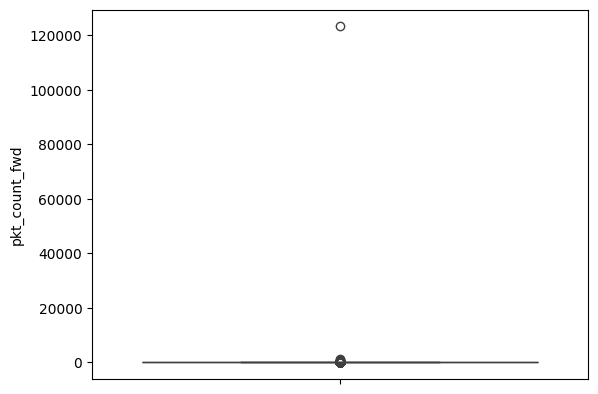

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
print(train['pkt_count_fwd'].skew())
sns.boxplot(train['pkt_count_fwd'])
plt.show()

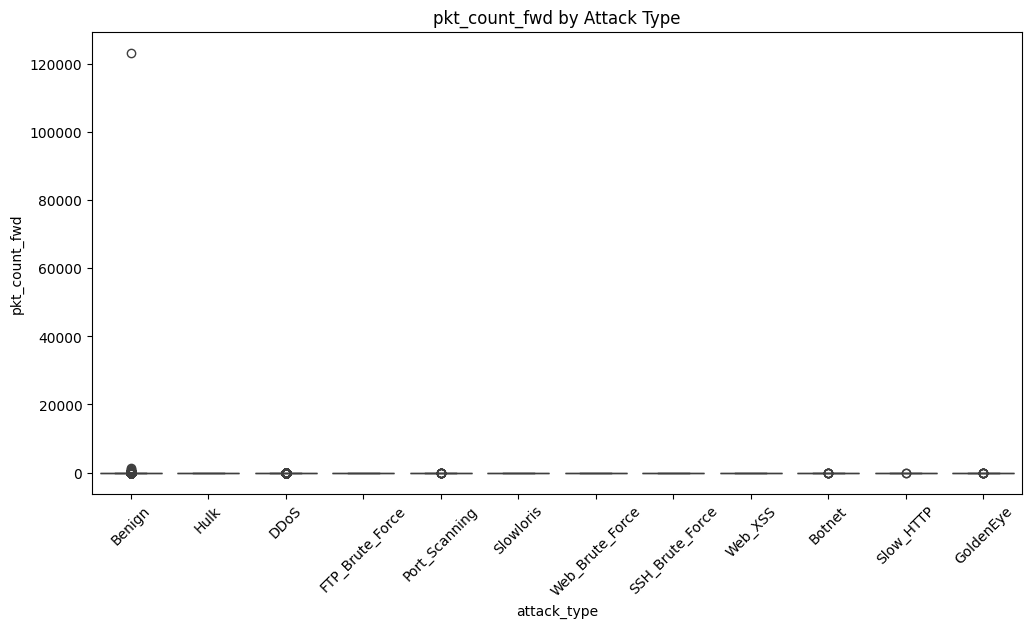

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='attack_type', y='pkt_count_fwd', data=train)
plt.xticks(rotation=45)
plt.title("pkt_count_fwd by Attack Type")
plt.show()

In [ ]:
train['pkt_count_fwd']=np.log1p(train['pkt_count_fwd'])

1.1437539407099746


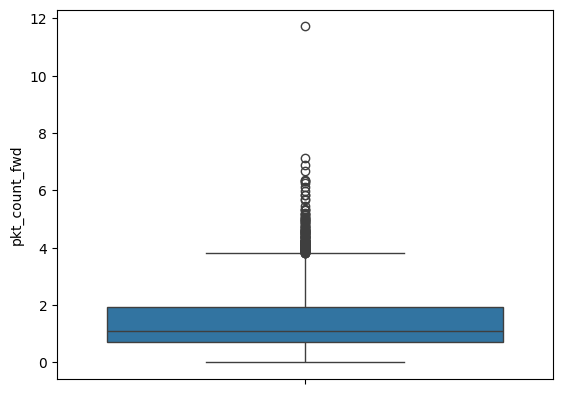

In [ ]:
# 로그변환 이후
print(train['pkt_count_fwd'].skew())
sns.boxplot(train['pkt_count_fwd'])
plt.show()

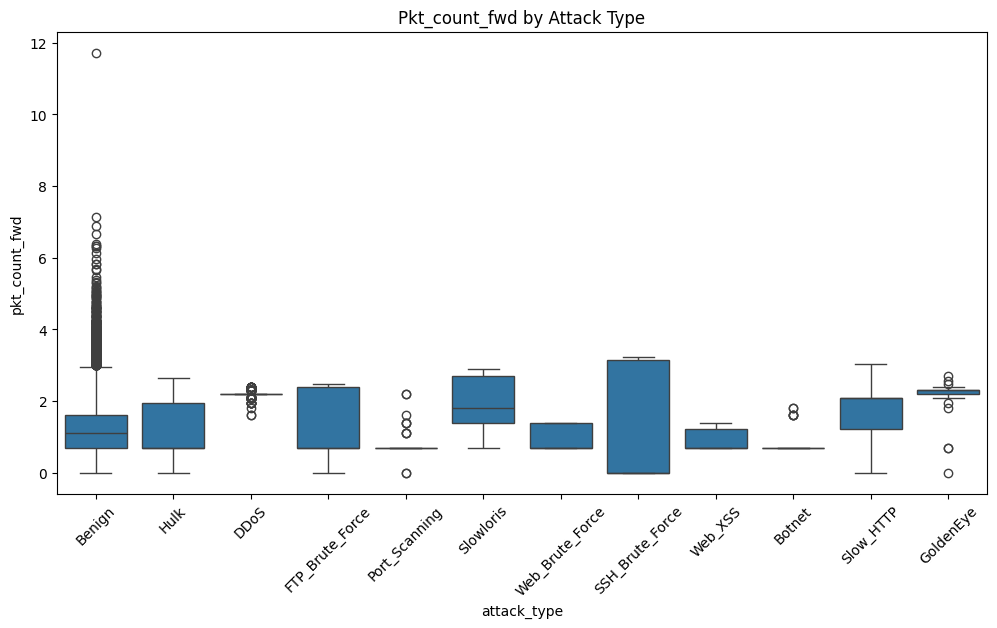

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='attack_type', y='pkt_count_fwd', data=train)
plt.xticks(rotation=45)
plt.title("Pkt_count_fwd by Attack Type")
plt.show()

pkt_count_bwd의 경우에는 boxplot과 왜도를 보게 되면 왜도가 10이상으로 로그변환을 하는 것이 좋을 것 같다.

**-> pkt_count_bwd : 로그변환**

109.4651942237973


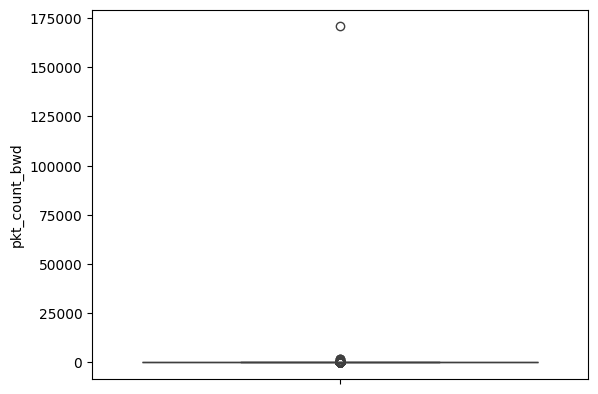

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
print(train['pkt_count_bwd'].skew())
sns.boxplot(train['pkt_count_bwd'])
plt.show()

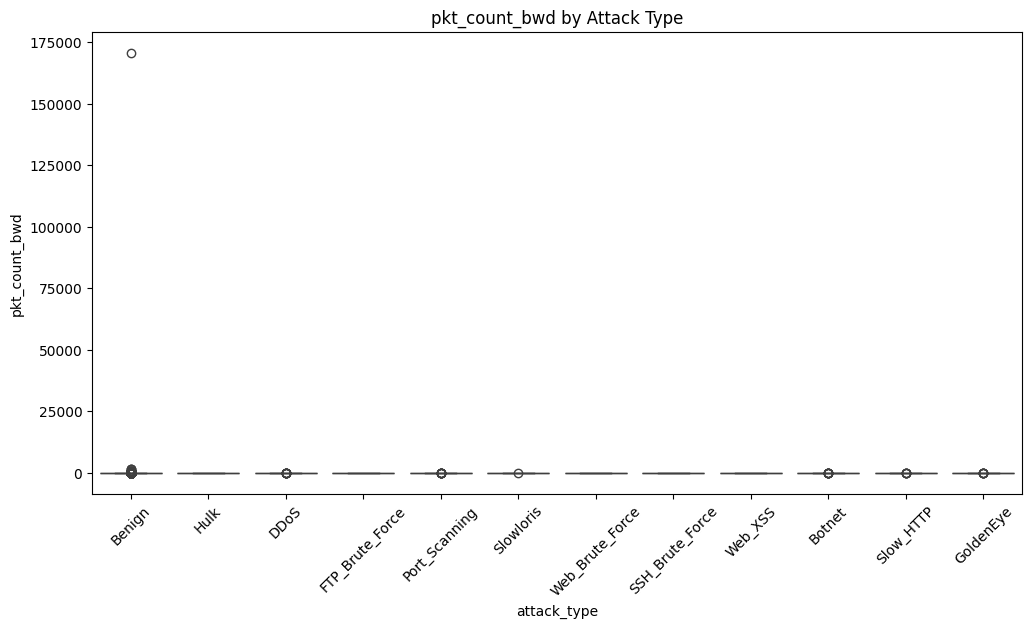

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='attack_type', y='pkt_count_bwd', data=train)
plt.xticks(rotation=45)
plt.title("pkt_count_bwd by Attack Type")
plt.show()

In [ ]:
train['pkt_count_bwd']=np.log1p(train['pkt_count_bwd'])

1.306808770337218


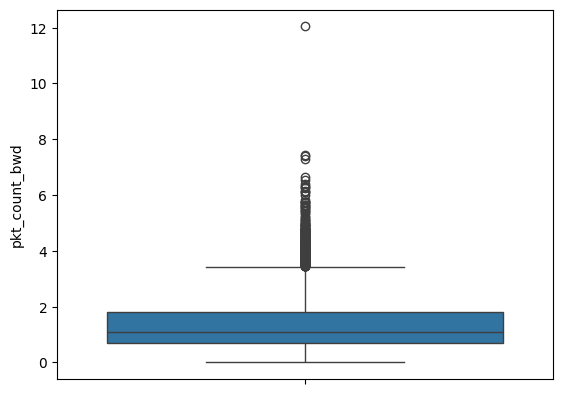

In [ ]:
# 로그변환 이후
print(train['pkt_count_bwd'].skew())
sns.boxplot(train['pkt_count_bwd'])
plt.show()

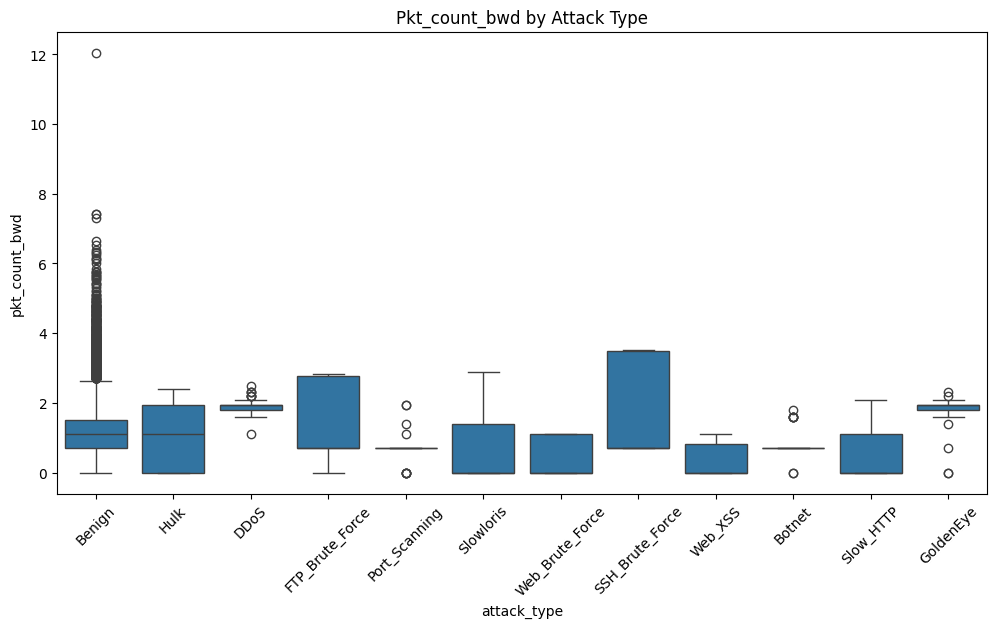

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='attack_type', y='pkt_count_bwd', data=train)
plt.xticks(rotation=45)
plt.title("Pkt_count_bwd by Attack Type")
plt.show()

rate_fwd_pkts의 경우에는 히스토그램과 왜도를 보게 되면 왜도가 10이상으로 로그변환을 하는 것이 좋을 것 같다. 그래서 결측치를 처리할때에 평균보다는 중앙값을 이용하는 것이 좋을 것 같다.

**-> rate_fwd_pkts : 결측치는 중앙값으로 + 로그변환**

16.06879066628271


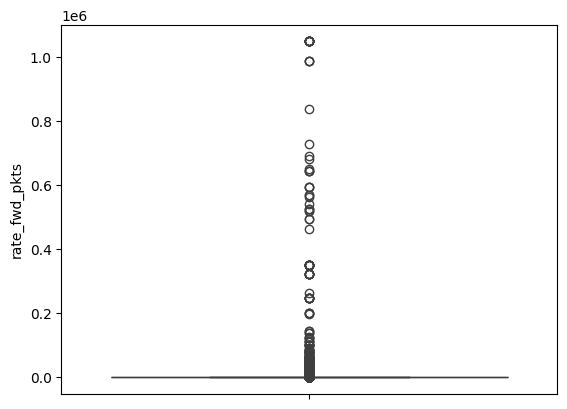

In [ ]:
print(train['rate_fwd_pkts'].skew())
sns.boxplot(train['rate_fwd_pkts'])
plt.show()

In [ ]:
#duration에서 결측치를 중앙값으로 처리
train['rate_fwd_pkts'].fillna(train['rate_fwd_pkts'].median())

0        8656.974200
1           0.000000
2          18.151760
3           5.977114
4           7.683389
            ...     
11994      42.308586
11995      16.272824
11996      40.021603
11997      41.813002
11998      47.062961
Name: rate_fwd_pkts, Length: 11999, dtype: float64

In [ ]:
train['rate_fwd_pkts']=np.log1p(train['rate_fwd_pkts'])

0.8692386391149648


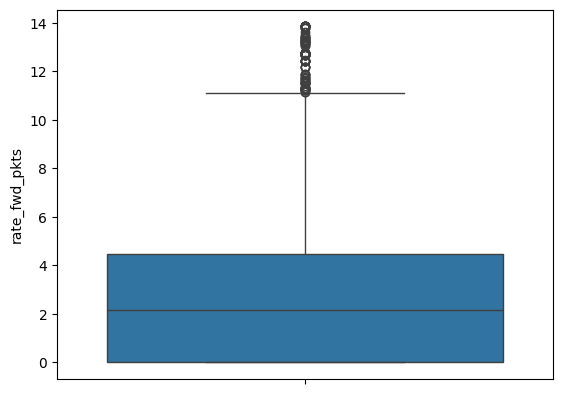

In [ ]:
#결측치 처리+로그변환 이후
print(train['rate_fwd_pkts'].skew())
sns.boxplot(train['rate_fwd_pkts'])
plt.show()

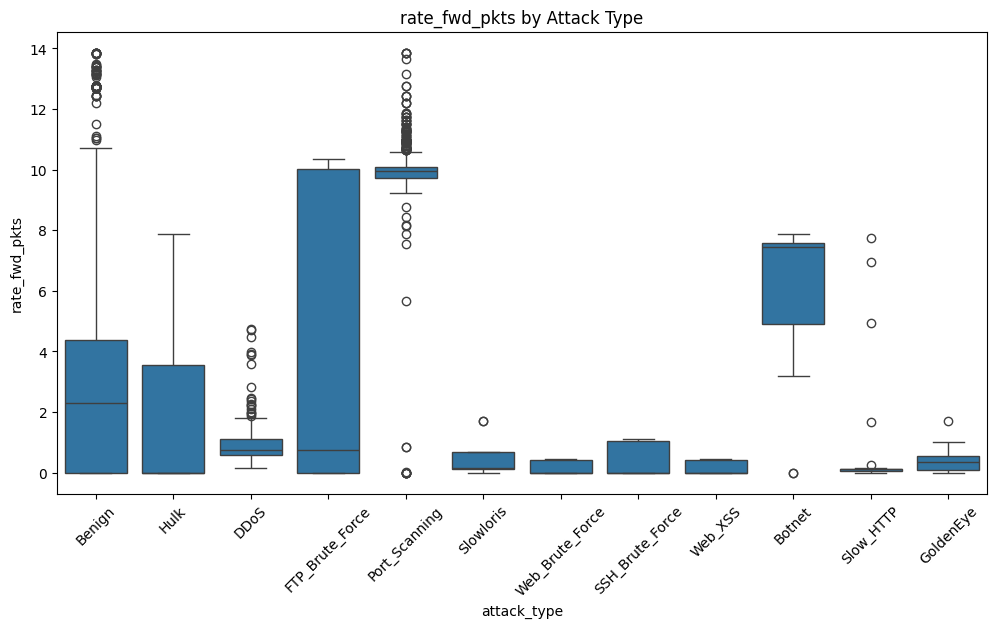

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='attack_type', y='rate_fwd_pkts', data=train)
plt.xticks(rotation=45)
plt.title("rate_fwd_pkts by Attack Type")
plt.show()

rate_bwd_pkts의 경우에는 히스토그램과 왜도를 보게 되면 왜도가 10이상으로 로그변환을 하는 것이 좋을 것 같다. 그래서 결측치를 처리할때에 평균보다는 중앙값을 이용하는 것이 좋을 것 같다.

**-> rate_bwd_pkts : 결측치는 중앙값으로 + 로그변환**

25.09097196663452


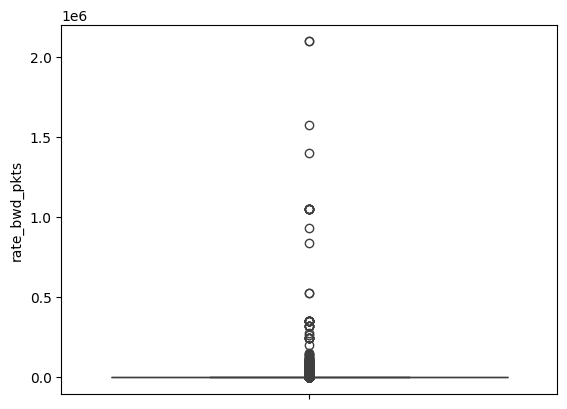

In [ ]:
print(train['rate_bwd_pkts'].skew())
sns.boxplot(train['rate_bwd_pkts'])
plt.show()

In [ ]:
#rate_bwd_pkts에서 결측치를 중앙값으로 처리
train['rate_bwd_pkts'].fillna(train['rate_fwd_pkts'].median())

0        8656.974200
1           0.000000
2           8.250800
3           5.977114
4           0.491183
            ...     
11994      42.308586
11995      16.272824
11996      40.021603
11997      41.813002
11998      29.414350
Name: rate_bwd_pkts, Length: 11999, dtype: float64

In [ ]:
train['rate_bwd_pkts']=np.log1p(train['rate_bwd_pkts'])

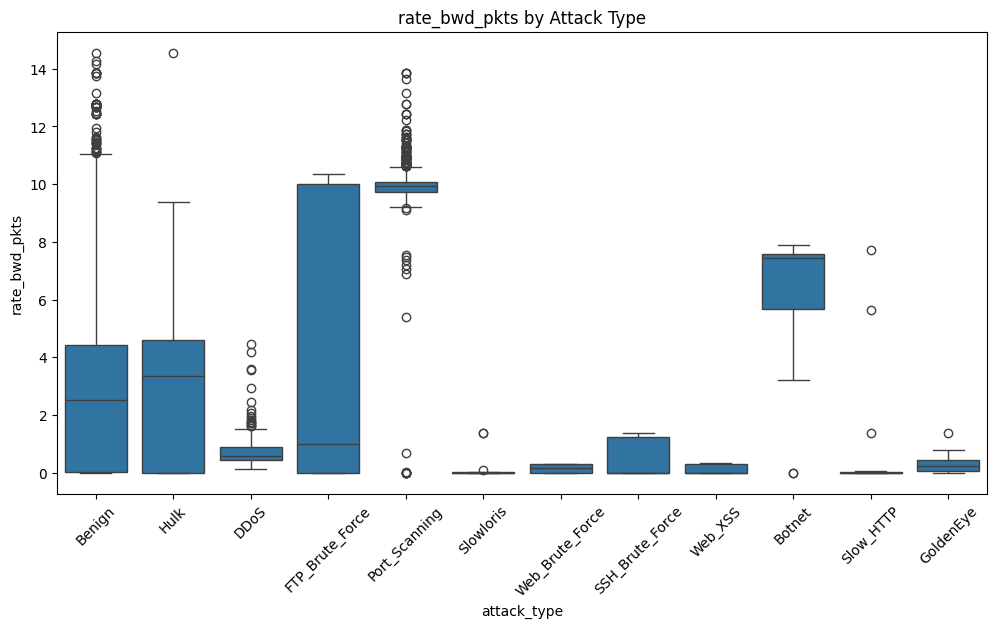

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='attack_type', y='rate_bwd_pkts', data=train)
plt.xticks(rotation=45)
plt.title("rate_bwd_pkts by Attack Type")
plt.show()

payload_fwd_mean는 그래프로 시각화를 하였을때, 왜도도 높지 않다. 결측치가 있는데, 값들이 넓게 펼쳐져 있으므로 중앙값으로 사용하는게 좋을 것 같다.

**->payload_fwd_mean: 결측치는 중앙값으로**

2.0789345831282606


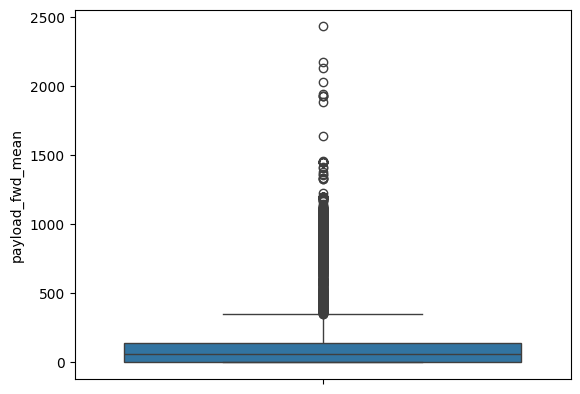

In [ ]:
print(train['payload_fwd_mean'].skew())
sns.boxplot(train['payload_fwd_mean'])
plt.show()

In [ ]:
train['payload_fwd_mean'].describe()

count    10214.000000
mean       183.602231
std        312.584458
min          0.000000
25%          0.000000
50%         61.500000
75%        141.000000
max       2433.333333
Name: payload_fwd_mean, dtype: float64

In [ ]:
#payload_fwd_mean에서 결측치를 중앙값으로 처리
train['payload_fwd_mean'].fillna(train['payload_fwd_mean'].median())

0         81.000000
1          0.000000
2        790.125000
3        993.416667
4         61.500000
            ...    
11994     91.000000
11995     61.000000
11996     66.000000
11997    103.500000
11998    916.538462
Name: payload_fwd_mean, Length: 11999, dtype: float64

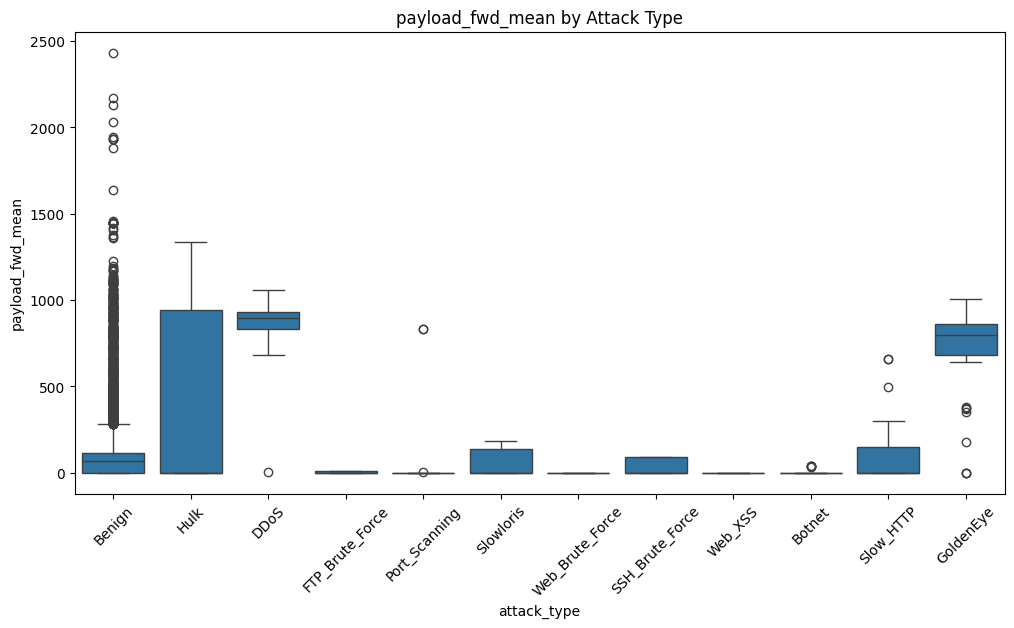

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='attack_type', y='payload_fwd_mean', data=train)
plt.xticks(rotation=45)
plt.title("payload_fwd_mean by Attack Type")
plt.show()

payload_bwd_mean는 그래프로 시각화를 하였을때, 왜도도 높지 않다. 결측치가 있는데, 값들이 넓게 펼쳐져 있으므로 중앙값으로 사용하는게 좋을 것 같다.

**->payload_bwd_mean: 결측치는 중앙값으로**

2.0789345831282606


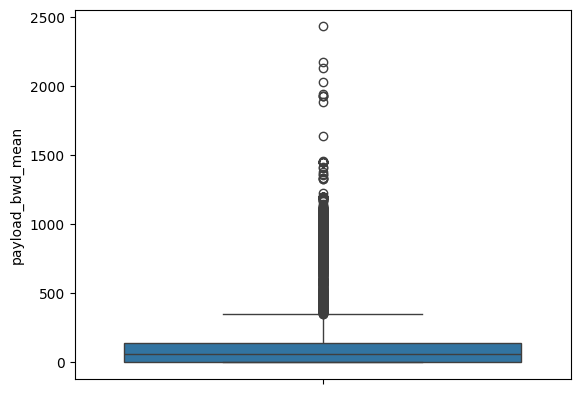

In [ ]:
print(train['payload_bwd_mean'].skew())
sns.boxplot(train['payload_bwd_mean'])
plt.show()

In [ ]:
train['payload_bwd_mean'].describe()

count    10214.000000
mean       183.602231
std        312.584458
min          0.000000
25%          0.000000
50%         61.500000
75%        141.000000
max       2433.333333
Name: payload_bwd_mean, dtype: float64

In [ ]:
#payload_bwd_mean에서 결측치를 중앙값으로 처리
train['payload_bwd_mean'].fillna(train['payload_bwd_mean'].median())

0         81.000000
1          0.000000
2        790.125000
3        993.416667
4         61.500000
            ...    
11994     91.000000
11995     61.000000
11996     66.000000
11997    103.500000
11998    916.538462
Name: payload_bwd_mean, Length: 11999, dtype: float64

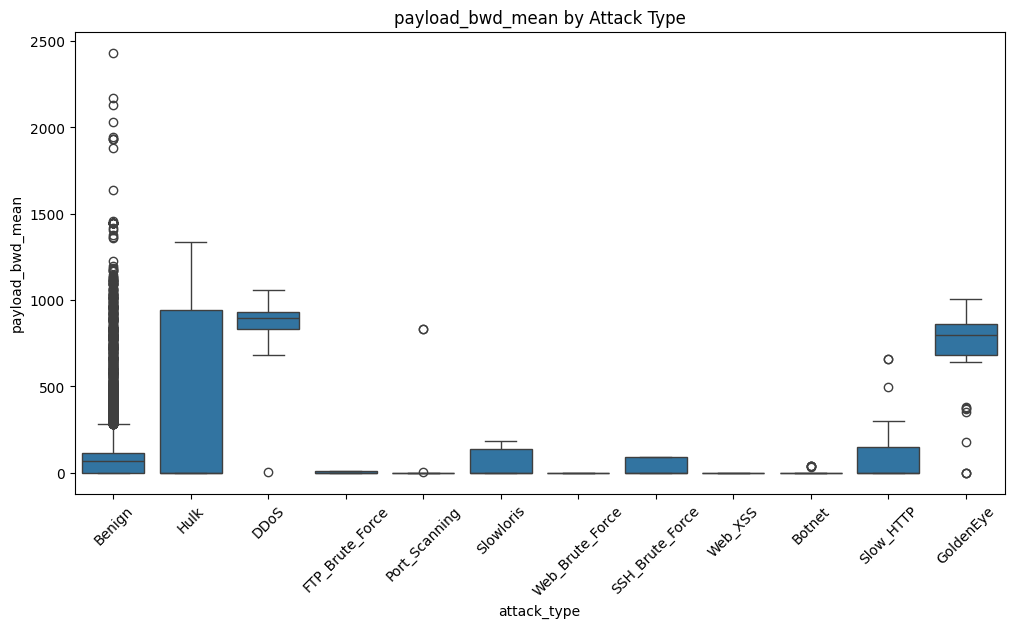

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='attack_type', y='payload_bwd_mean', data=train)
plt.xticks(rotation=45)
plt.title("payload_bwd_mean by Attack Type")
plt.show()

tcp_win_fwd_init는 그래프로 시각화를 하였을때, 왜도도 높지 않았다. 하지만, 50% 이상이 0으로 이루어져 있고, 최댓값이 65535여서 로그변환을 하는게 좋을 것 같다.

**->tcp_win_fwd_init: 로그변환**

2.10027058583249


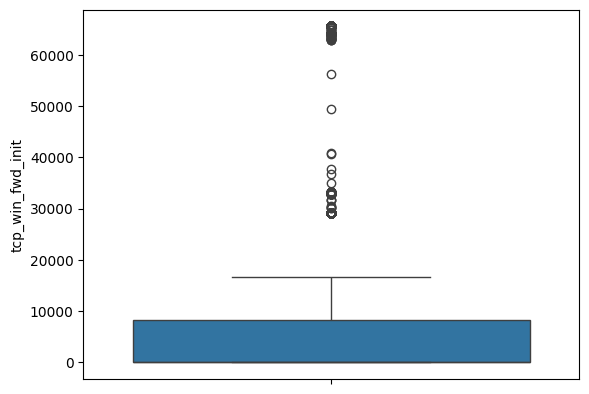

In [ ]:
print(train['tcp_win_fwd_init'].skew())
sns.boxplot(train['tcp_win_fwd_init'])
plt.show()

In [ ]:
train['tcp_win_fwd_init'].describe()

count    11999.000000
mean      8464.435870
std      15043.771463
min          0.000000
25%          0.000000
50%          0.000000
75%       8192.000000
max      65535.000000
Name: tcp_win_fwd_init, dtype: float64

In [ ]:
train['tcp_win_fwd_init']=np.log1p(train['tcp_win_fwd_init'])

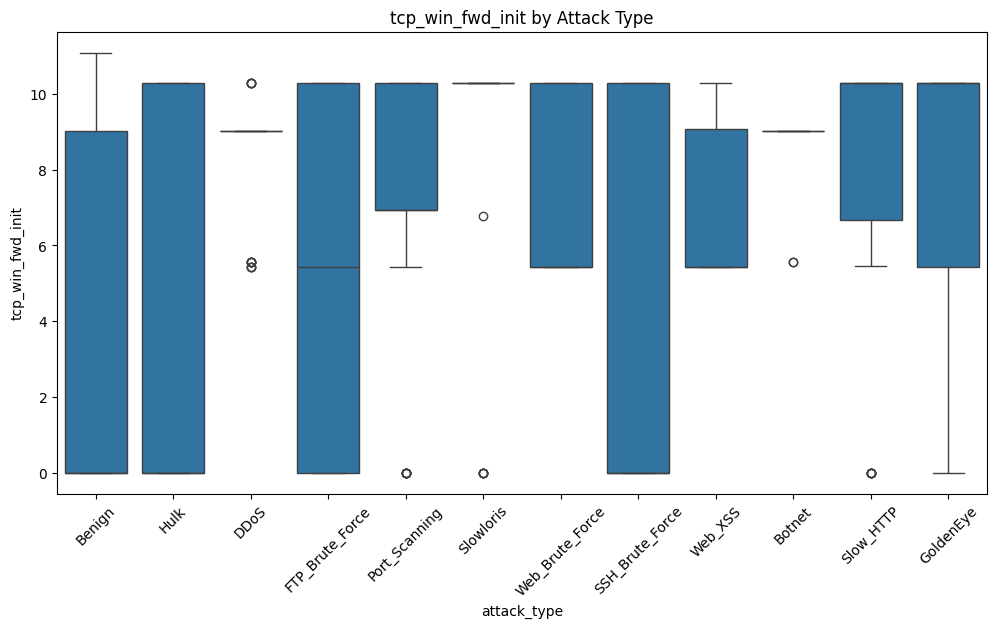

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='attack_type', y='tcp_win_fwd_init', data=train)
plt.xticks(rotation=45)
plt.title("tcp_win_fwd_init by Attack Type")
plt.show()

tcp_win_bwd_init는 그래프로 시각화를 하였을때, 왜도도 높지 않았다. 하지만, 50% 이상이 0으로 이루어져 있고, 최댓값이 65535여서 로그변환을 하는게 좋을 것 같다.

**->tcp_win_bwd_init: 로그변환**

1.3860472205838854


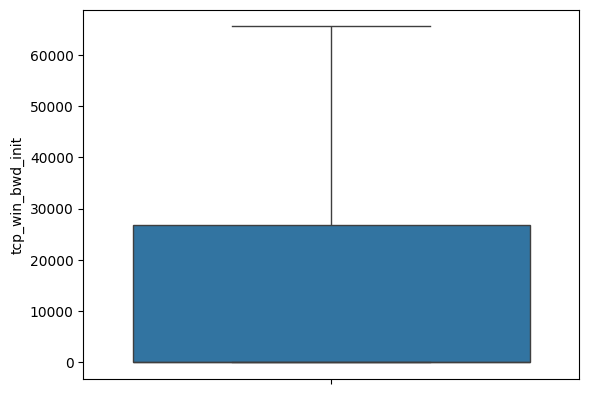

In [ ]:
print(train['tcp_win_bwd_init'].skew())
sns.boxplot(train['tcp_win_bwd_init'])
plt.show()

In [ ]:
train['tcp_win_bwd_init'].describe()

count    11999.000000
mean      8691.062839
std      14180.141107
min          0.000000
25%          0.000000
50%          0.000000
75%      26847.000000
max      65535.000000
Name: tcp_win_bwd_init, dtype: float64

In [ ]:
train['tcp_win_bwd_init']=np.log1p(train['tcp_win_bwd_init'])

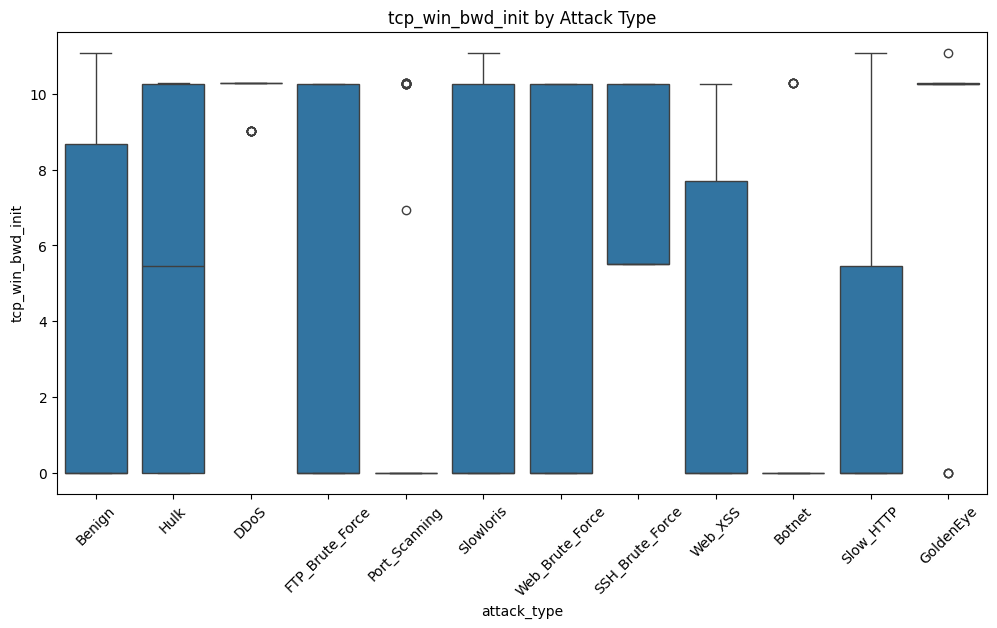

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='attack_type', y='tcp_win_bwd_init', data=train)
plt.xticks(rotation=45)
plt.title("tcp_win_bwd_init by Attack Type")
plt.show()

tcp_syn_count는 결측치가 없다. 그래프를 시각화하였을때 왜도가 작고, 값이 넓게 펼쳐져 있지 않아서 그대로 사용해도 괜찮을 것 같다.

**->tcp_syn_count : 그대로 사용**

1.2675425048521698


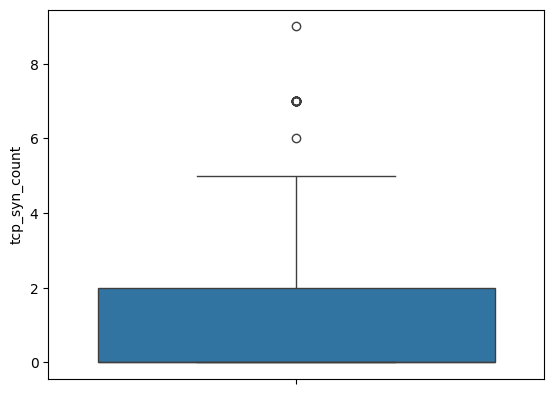

In [ ]:
print(train['tcp_syn_count'].skew())
sns.boxplot(train['tcp_syn_count'])
plt.show()

In [ ]:
train['tcp_syn_count'].describe()

count    11999.000000
mean         0.713976
std          1.010957
min          0.000000
25%          0.000000
50%          0.000000
75%          2.000000
max          9.000000
Name: tcp_syn_count, dtype: float64

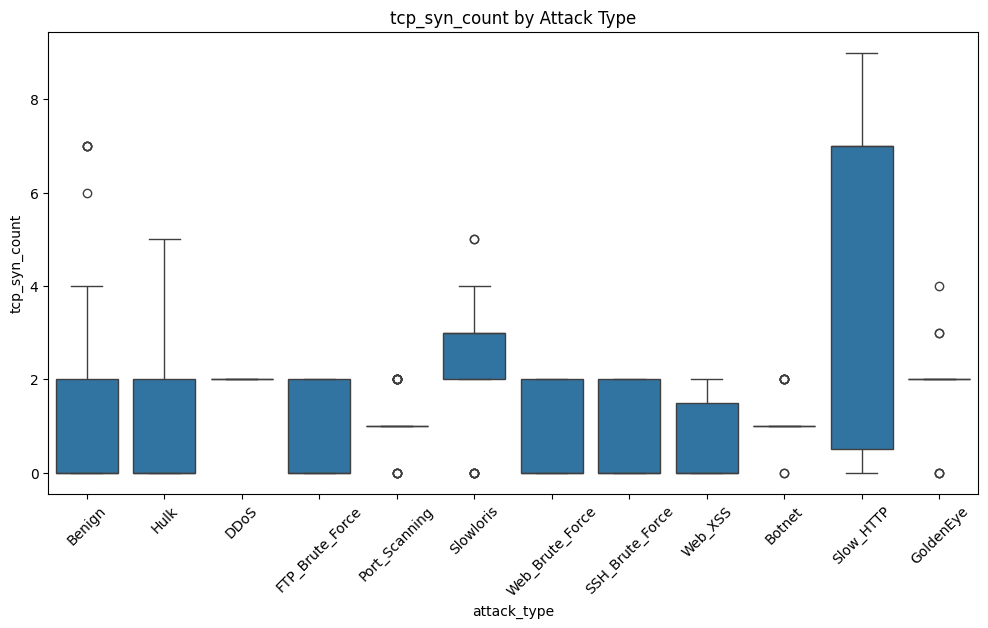

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='attack_type', y='tcp_syn_count', data=train)
plt.xticks(rotation=45)
plt.title("tcp_syn_count by Attack Type")
plt.show()

tcp_psh_count는 그래프로 시각화를 하였을때, 왜도도 높지 않았다. 하지만, 50% 이상이 0으로 이루어져 있고, 최댓값이 1046여서 로그변환을 하는게 좋을 것 같다.

**->tcp_psh_count: 로그변환**

44.45139889259434


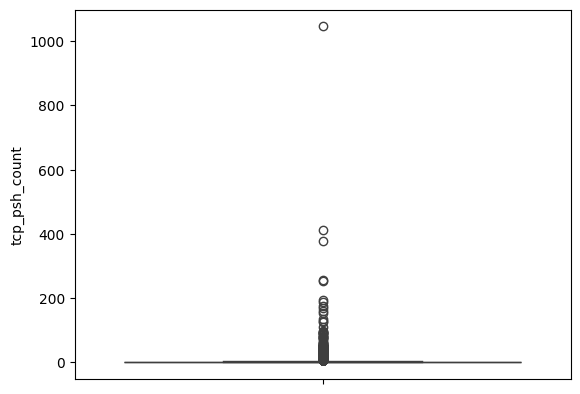

In [ ]:
print(train['tcp_psh_count'].skew())
sns.boxplot(train['tcp_psh_count'])
plt.show()

In [ ]:
train['tcp_psh_count'].describe()

count    11999.000000
mean         2.409451
std         13.620653
min          0.000000
25%          0.000000
50%          0.000000
75%          2.000000
max       1046.000000
Name: tcp_psh_count, dtype: float64

In [ ]:
train['tcp_psh_count']=np.log1p(train['tcp_psh_count'])

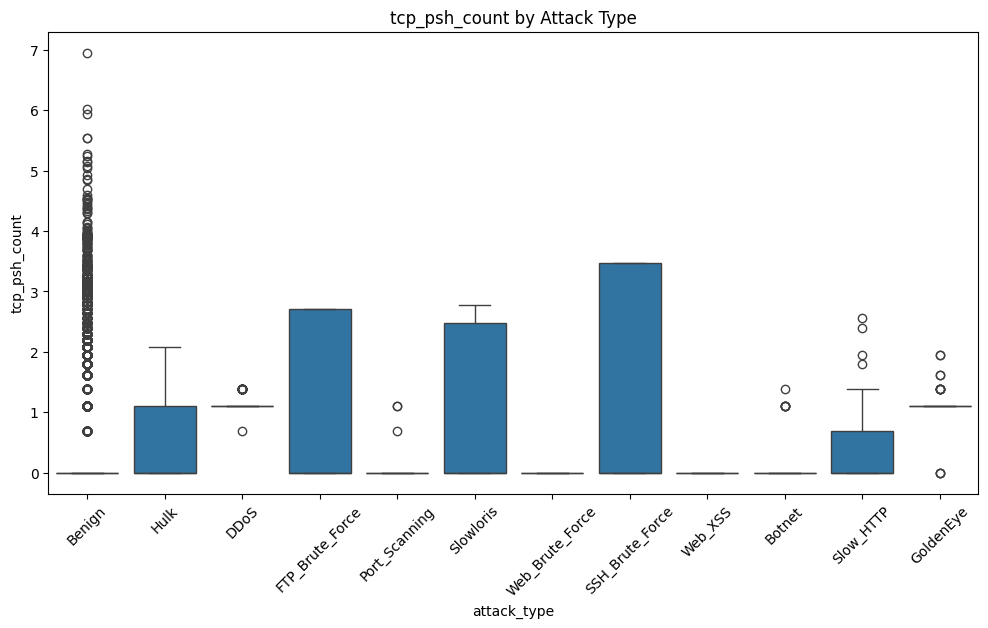

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='attack_type', y='tcp_psh_count', data=train)
plt.xticks(rotation=45)
plt.title("tcp_psh_count by Attack Type")
plt.show()

tcp_rst_count는 0에서 1 사이에 있고, 결측치도 있지 않아서 그대로 사용해도 괜찮을 것 같다.

**-> tcp_rst_count : 그대로 사용**

In [ ]:
train['tcp_rst_count'].describe()

count    11999.000000
mean         0.324027
std          0.468030
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: tcp_rst_count, dtype: float64

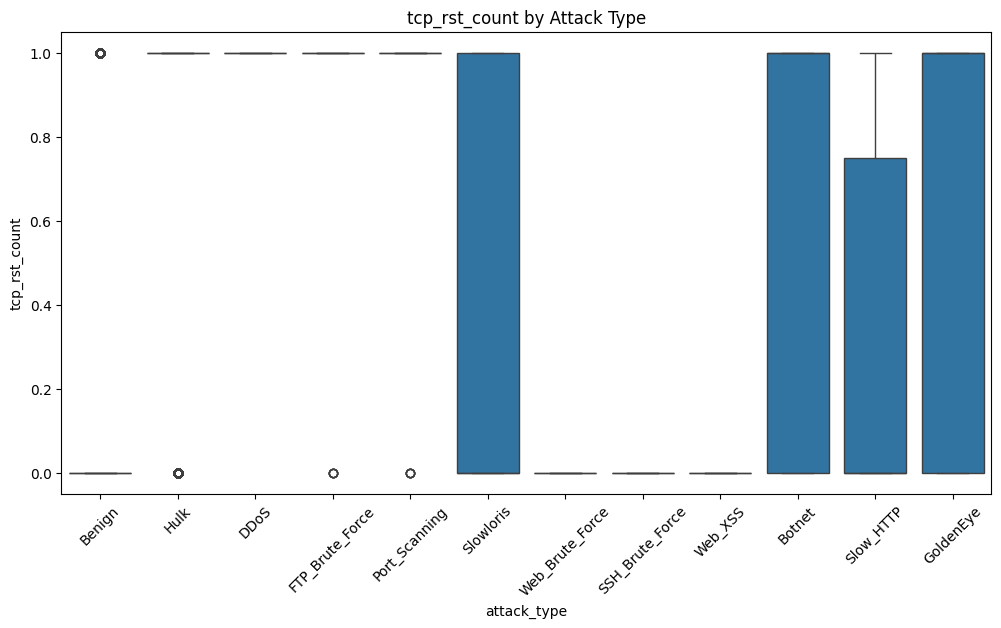

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='attack_type', y='tcp_rst_count', data=train)
plt.xticks(rotation=45)
plt.title("tcp_rst_count by Attack Type")
plt.show()

**->iat_avg_packets : 결측치는 중앙값으로**

In [ ]:
print(train['iat_avg_packets'].skew())

1.3008918113839658


In [ ]:
train['iat_avg_packets'].describe()

count    9.239000e+03
mean     3.409358e+08
std      6.284508e+08
min      0.000000e+00
25%      1.738550e-03
50%      4.816914e-02
75%      1.954012e+01
max      1.499458e+09
Name: iat_avg_packets, dtype: float64

In [ ]:
#iat_avg_packets에서 결측치를 중앙값으로 처리
train['iat_avg_packets'].fillna(train['iat_avg_packets'].median())

0        4.816914e-02
1        1.499097e+09
2        4.040012e-02
3        9.125718e-02
4        4.816914e-02
             ...     
11994    2.363586e-02
11995    6.145215e-02
11996    1.665767e-02
11997    1.594400e-02
11998    1.416542e-02
Name: iat_avg_packets, Length: 11999, dtype: float64

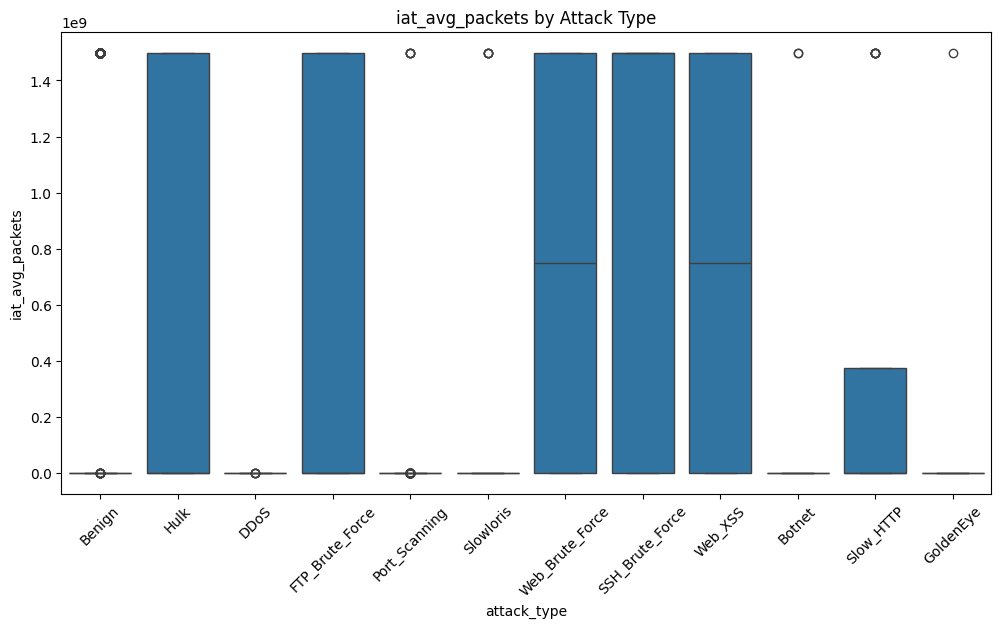

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='attack_type', y='iat_avg_packets', data=train)
plt.xticks(rotation=45)
plt.title("iat_avg_packets by Attack Type")
plt.show()

# 파생 변수 만들기

**1.   is_https**

HTTP(S)는 port_dst가 (80/443)이므로 is_https 파생변수 만들기

In [ ]:
train['is_http'] = train['port_dst'].apply(lambda x: 1 if x in [80, 443] else 0)

**2.   is_ssh**

SSH는 port_dst가 22이므로 is_ssh 파생변수 만들기

In [ ]:
train['is_ssh'] = train['port_dst'].apply(lambda x: 1 if x in [22] else 0)

**3.   pkt_ratio**

pkt_ratio=pkt_count_fwd / (pkt_count_bwd + 1)인데, 이때 pkt_count_bwd가 0이면 분모가 0이 되므로 이것을 막고자 1을 더했다.

In [ ]:
train["pkt_ratio"] = train["pkt_count_fwd"] / (train["pkt_count_bwd"] + 1)

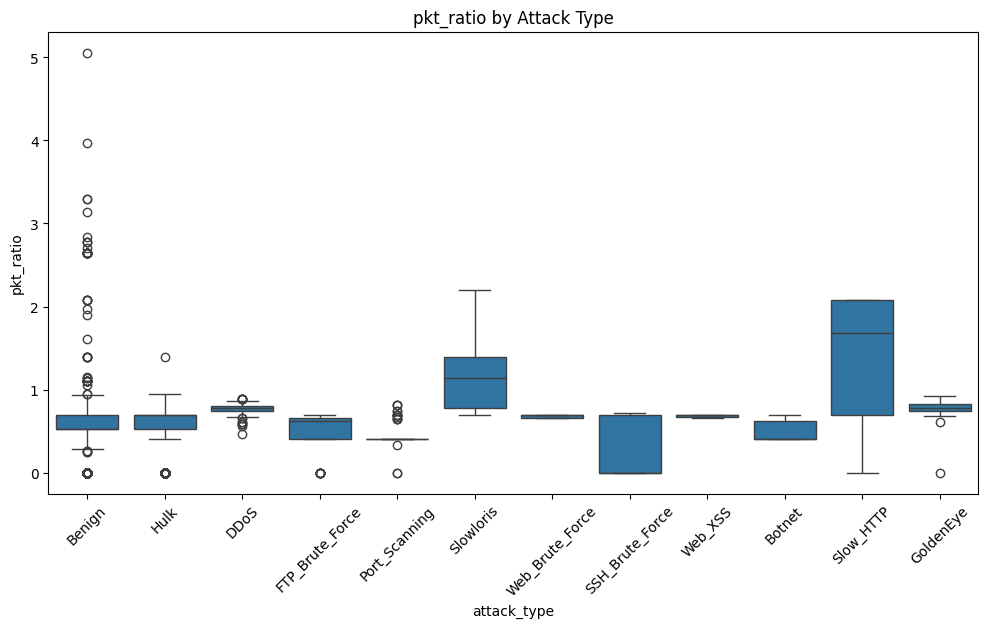

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='attack_type', y='pkt_ratio', data=train)
plt.xticks(rotation=45)
plt.title("pkt_ratio by Attack Type")
plt.show()

In [ ]:
train.select_dtypes(include=['number']).corr()

port_dst  duration  pkt_count_fwd  pkt_count_bwd  \
port_dst          1.000000 -0.181324      -0.432442      -0.141292   
duration         -0.181324  1.000000       0.650567       0.620717   
pkt_count_fwd    -0.432442  0.650567       1.000000       0.871328   
pkt_count_bwd    -0.141292  0.620717       0.871328       1.000000   
rate_fwd_pkts    -0.123916 -0.372453      -0.070933      -0.053755   
rate_bwd_pkts     0.113484 -0.408880      -0.211748      -0.048275   
rate_fwd_bytes    0.040229 -0.024943       0.016777      -0.041669   
rate_bwd_bytes    0.033787 -0.076153      -0.041598      -0.004495   
payload_fwd_mean -0.161225  0.206967       0.562983       0.551829   
payload_bwd_mean -0.161225  0.206967       0.562983       0.551829   
tcp_win_fwd_init -0.207994  0.383795       0.635029       0.519691   
tcp_win_bwd_init  0.059731  0.464973       0.668143       0.744932   
tcp_syn_count    -0.216712  0.486733       0.754257       0.690767   
tcp_psh_count    -0.188657  0.579750       0.874818       0.861880   
tcp_rst_count     0.144679 -0.128353      -0.132442      -0.151001   
iat_avg_packets   0.211954 -0.269432      -0.466203      -0.573796   
is_http          -0.057252  0.037143       0.076575       0.047326   
is_ssh           -0.008876  0.005042       0.015694       0.020288   
pkt_ratio        -0.606896  0.344050       0.655564       0.226864   

                  rate_fwd_pkts  rate_bwd_pkts  rate_fwd_bytes  \
port_dst              -0.123916       0.113484        0.040229   
duration              -0.372453      -0.408880       -0.024943   
pkt_count_fwd         -0.070933      -0.211748        0.016777   
pkt_count_bwd         -0.053755      -0.048275       -0.041669   
rate_fwd_pkts          1.000000       0.878260        0.110733   
rate_bwd_pkts          0.878260       1.000000        0.016607   
rate_fwd_bytes         0.110733       0.016607        1.000000   
rate_bwd_bytes         0.206951       0.255772        0.017766   
payload_fwd_mean      -0.041662      -0.088781        0.070797   
payload_bwd_mean      -0.041662      -0.088781        0.070797   
tcp_win_fwd_init      -0.055609      -0.141425       -0.018285   
tcp_win_bwd_init      -0.313505      -0.268428       -0.036194   
tcp_syn_count         -0.117994      -0.181854       -0.033956   
tcp_psh_count         -0.217390      -0.264511       -0.019445   
tcp_rst_count         -0.021194       0.052592       -0.001510   
iat_avg_packets       -0.480967      -0.510495       -0.025481   
is_http               -0.070791      -0.077362       -0.006533   
is_ssh                 0.009806       0.010028       -0.001022   
pkt_ratio             -0.029096      -0.279730        0.150615   

                  rate_bwd_bytes  payload_fwd_mean  payload_bwd_mean  \
port_dst                0.033787         -0.161225         -0.161225   
duration               -0.076153          0.206967          0.206967   
pkt_count_fwd          -0.041598          0.562983          0.562983   
pkt_count_bwd          -0.004495          0.551829          0.551829   
rate_fwd_pkts           0.206951         -0.041662         -0.041662   
rate_bwd_pkts           0.255772         -0.088781         -0.088781   
rate_fwd_bytes          0.017766          0.070797          0.070797   
rate_bwd_bytes          1.000000          0.053881          0.053881   
payload_fwd_mean        0.053881          1.000000          1.000000   
payload_bwd_mean        0.053881          1.000000          1.000000   
tcp_win_fwd_init       -0.093703          0.476783          0.476783   
tcp_win_bwd_init       -0.051451          0.609294          0.609294   
tcp_syn_count          -0.079743          0.578415          0.578415   
tcp_psh_count          -0.048575          0.505332          0.505332   
tcp_rst_count          -0.040305          0.169647          0.169647   
iat_avg_packets        -0.082015         -0.319113         -0.319113   
is_http                -0.016223          0.071619          0.071619   


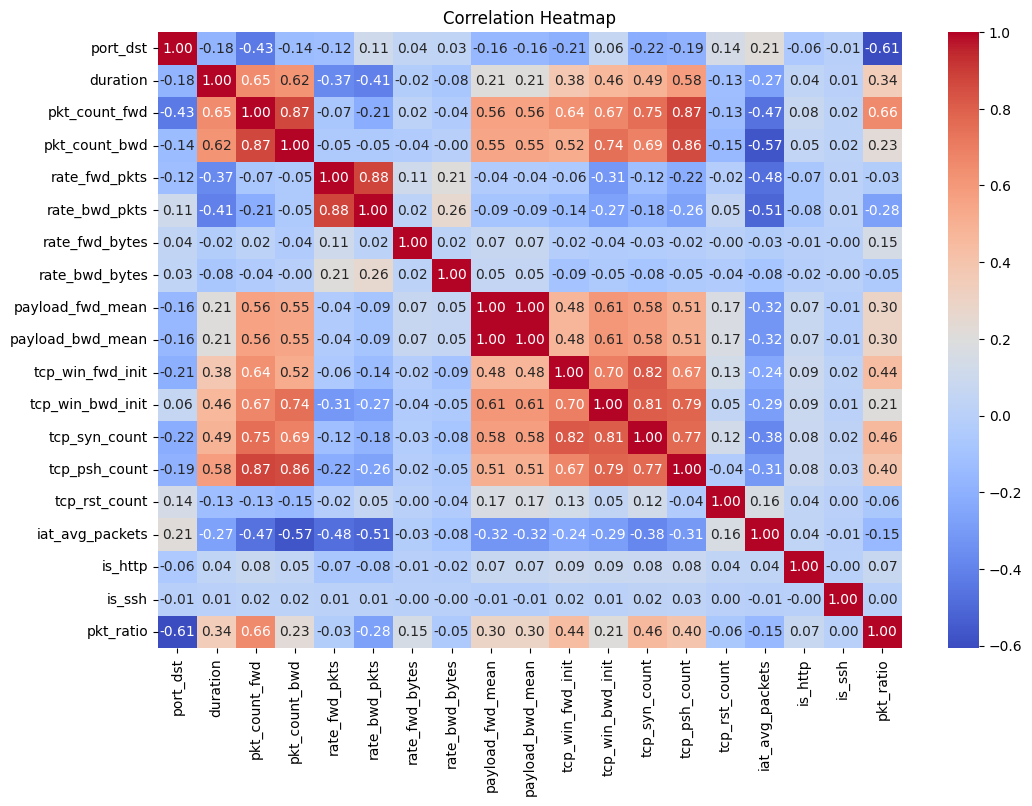

In [ ]:
# 숫자형 변수만 추려서 상관계수 행렬 계산
corr = train.select_dtypes(include='number').corr()

# heatmap 시각화
plt.figure(figsize=(12, 8))  # 크기 조절 (선택)
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()